In [1]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/kaggle"

# Download the dataset from Kaggle using the Kaggle API
!kaggle datasets download -d arnavr10880/concrete-crack-images-for-classification

# Unzip the downloaded dataset (if it's in zip format)
!unzip -q /kaggle/working/concrete-crack-images-for-classification.zip -d /kaggle/working/concrete_crack_dataset

# List files in the directory to confirm the dataset has been downloaded
!ls /kaggle/working/concrete_crack_dataset


Dataset URL: https://www.kaggle.com/datasets/arnavr10880/concrete-crack-images-for-classification
License(s): Attribution 4.0 International (CC BY 4.0)
 93%|█████████████████████████████████████▏  | 217M/233M [00:01<00:00, 82.2MB/s]
100%|█████████████████████████████████████████| 233M/233M [00:01<00:00, 134MB/s]
Negative  Positive


In [2]:
!pip install split-folders

In [3]:
import os
import shutil
import splitfolders

file_path = '/kaggle/working/concrete_crack_dataset'
splitted_folder = 'data'

# Delete existing folder and create a new one
if not os.path.exists(splitted_folder):
    os.makedirs(splitted_folder)
else:
    shutil.rmtree(splitted_folder, ignore_errors=True)
    print("Deleted '%s' directory successfully" % splitted_folder)
    os.makedirs(splitted_folder)

def train_test_valid(images_folder=file_path, splitted_folder=splitted_folder):
    input_folder = images_folder
    output_folder = splitted_folder
    splitfolders.ratio(input_folder, output_folder, seed=1337, ratio=(.8, 0.1, 0.1), group_prefix=None)

train_test_valid()


Copying files: 40000 files [00:05, 7041.10 files/s]


In [4]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

# Define data directories
data_dir = 'data'  # Change to your dataset directory

# Load datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

# Create data loaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True) for x in ['train', 'val', 'test']}

# Size of each dataset
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Number of classes
num_classes = len(image_datasets['train'].classes)
print(num_classes)

# Class names
class_names = image_datasets['train'].classes
print(class_names)


2
['Negative', 'Positive']


In [5]:
def _approximated_ReLU(x):
    return 0.117071 * x**2 + 0.5 * x + 0.375373

class Square(torch.nn.Module):
    def forward(self, x):
        return x**2

class ApproxReLU(torch.nn.Module):
    def forward(self, x):
        return _approximated_ReLU(x)

class Flatten(torch.nn.Module):
    def forward(self, x):
        return torch.flatten(x, 1)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# class CNN_approx(nn.Module):
#   def __init__(self):
#     super(CNN_approx, self).__init__()
#     self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#     self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#     self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#     self.pool = nn.AvgPool2d(2, 2)
#     self.fc1 = nn.Linear(128 * 28 * 28, 1024)
#     self.fc2 = nn.Linear(1024, 1024)
#     self.fc3 = nn.Linear(1024, 2)  # Output has 2 classes
#     self.approx_relu = ApproxReLU()

#   def forward(self, x):
#     x = self.pool(self.approx_relu(self.conv1(x)))
#     x = self.pool(self.approx_relu(self.conv2(x)))
#     x = self.pool(self.approx_relu(self.conv3(x)))
#     x = torch.flatten(x, 1)
#     x = self.approx_relu(self.fc1(x))
#     x = self.approx_relu(self.fc2(x))
#     x = self.fc3(x)
#     return x
class CNN_approx(nn.Module):
    def __init__(self):
        super(CNN_approx, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(2, 2)  # Changed to AvgPool2d
        self.fc1 = nn.Linear(128 * 28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 2)  # Output has 2 classes

    def forward(self, x):
        x = self.pool(_approximated_ReLU(self.conv1(x)))
        x = self.pool(_approximated_ReLU(self.conv2(x)))
        x = self.pool(_approximated_ReLU(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = _approximated_ReLU(self.fc1(x))
        x = _approximated_ReLU(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the PyTorch model
model = CNN_approx()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the PyTorch model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNN_approx(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=100352, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=2, bias=True)
)

Epoch [1/15], Train Loss: 0.6651, Val Loss: 0.5542, Train Acc: 0.5895, Val Acc: 0.7518
Epoch [2/15], Train Loss: 0.4670, Val Loss: 0.4139, Train Acc: 0.8116, Val Acc: 0.8027
Epoch [3/15], Train Loss: 0.3566, Val Loss: 0.3670, Train Acc: 0.8665, Val Acc: 0.8405
Epoch [4/15], Train Loss: 0.3126, Val Loss: 0.2795, Train Acc: 0.8869, Val Acc: 0.9105
Epoch [5/15], Train Loss: 0.2802, Val Loss: 0.2586, Train Acc: 0.9022, Val Acc: 0.9270
Epoch [6/15], Train Loss: 0.2391, Val Loss: 0.2019, Train Acc: 0.9189, Val Acc: 0.9380
Epoch [7/15], Train Loss: 0.1823, Val Loss: 0.1933, Train Acc: 0.9410, Val Acc: 0.9345
Epoch [8/15], Train Loss: 0.1442, Val Loss: 0.1162, Train Acc: 0.9559, Val Acc: 0.9603
Epoch [9/15], Train Loss: 0.1153, Val Loss: 0.1072, Train Acc: 0.9650, Val Acc: 0.9650
Epoch [10/15], Train Loss: 0.1026, Val Loss: 0.0936, Train Acc: 0.9711, Val Acc: 0.9740
Epoch [11/15], Train Loss: 0.0995, Val Loss: 0.0976, Train Acc: 0.9722, Val Acc: 0.9688
Epoch [12/15], Train Loss: 0.0931, Val Lo

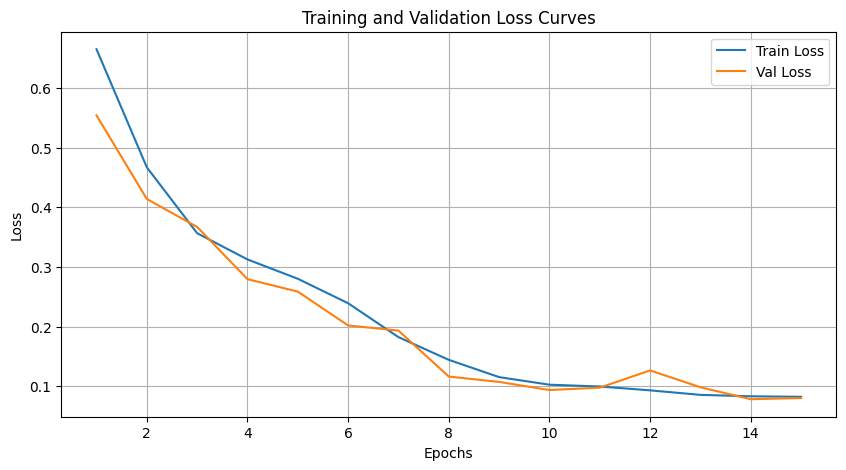

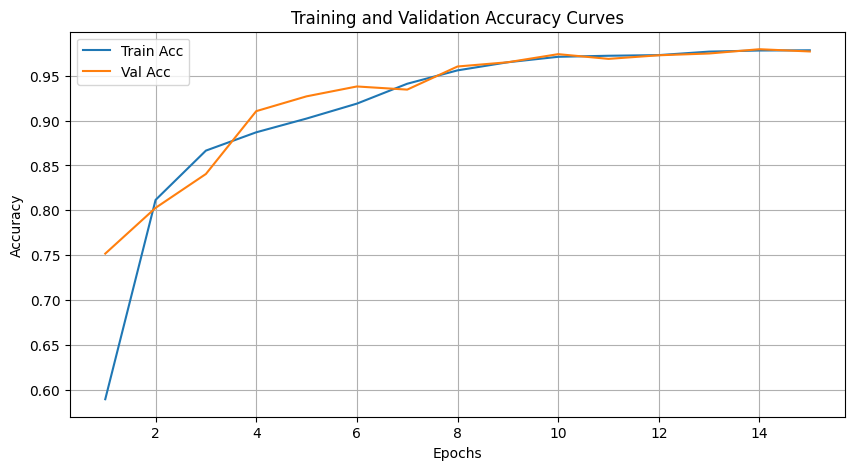

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Initialize lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# Train the PyTorch model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize the learning rate and define gradient clipping threshold
lr = 0.001
clip_value = 1.0 

# Create optimizer with initial learning rate
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

for epoch in range(15):
    # Set the model to training mode
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate training loss and accuracy
    epoch_loss = running_loss / len(image_datasets['train'])
    train_losses.append(epoch_loss)
    train_acc = correct_train / total_train
    train_accs.append(train_acc)

    # Set the model to evaluation mode
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate validation loss and accuracy
    val_loss /= len(image_datasets['val'])
    val_losses.append(val_loss)
    val_acc = correct_val / total_val
    val_accs.append(val_acc)

    # Print epoch statistics
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}, Train Acc: {:.4f}, Val Acc: {:.4f}'.format(
        epoch+1, 15, epoch_loss, val_loss, train_acc, val_acc))

    # Reduce learning rate
    lr *= 0.9
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, 16), train_losses, label='Train Loss')
plt.plot(range(1, 16), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, 16), train_accs, label='Train Acc')
plt.plot(range(1, 16), val_accs, label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Save the trained model's weights
torch.save(model.state_dict(), 'M7_model.pth')
